# Xây dựng mô hình
Chúng ta sẽ xây dựng 3 mô hình cơ bản 

In [56]:
import numpy as np
import matplotlib.pyplot as plt

## I. Thuật toán hồi quy Logistic (Logistic Regression) sử dụng phương pháp Gradient Descent.

Đây là một thuật toán học máy có giám sát (supervised learning) được sử dụng cho bài toán **phân loại nhị phân** (binary classification) - ví dụ: phân loại 0 hoặc 1, đúng hoặc sai.

---

Việc huấn luyện mô hình để tìm ra bộ tham số trọng số ($w$) và hệ số chệch ($b$) tốt nhất, giúp phân tách dữ liệu thành 2 lớp. Quá trình này diễn ra như sau:

### Bước 1: Khởi tạo (Initialization)

  * **Mục đích:** Tạo điểm bắt đầu cho mô hình.
  * **Trong code:** `self.w = np.zeros(n)` và `self.b = 0`.
  * **Giải thích:** Ban đầu, mô hình chưa học được gì nên ta đặt trọng số $w$ là một vector số 0 và $b$ là 0.

### Bước 2: Quá trình Huấn luyện (Training Loop - `fit`)

Vòng lặp chạy `epochs` lần, mỗi lần lặp gồm 3 pha chính:

**Pha 1: Lan truyền xuôi (Forward Propagation - Prediction)**

1.  **Tính tổ hợp tuyến tính ($z$):**
      * Công thức: $z = w \cdot X + b$.
      * Đây là phương trình đường thẳng (hoặc siêu phẳng) phân chia không gian dữ liệu.
2.  **Hàm kích hoạt Sigmoid:**
      * Công thức: $\hat{y} = \frac{1}{1 + e^{-z}}$.
      * **Trong code:** `np.clip(z, -250, 250)` được dùng trước khi đưa vào hàm mũ `np.exp`. Điều này để tránh lỗi tràn số (overflow) khi $z$ quá lớn hoặc quá nhỏ, giữ cho việc tính toán ổn định.
      * Kết quả $\hat{y}$ (biến `y_pred`) là xác suất (từ 0 đến 1) điểm dữ liệu thuộc về lớp 1.

**Pha 2: Tính Gradient (Gradient Calculation)**

  * Mục đích: Tính toán đạo hàm của hàm mất mát (Loss function) để biết mô hình đang sai lệch bao nhiêu và cần điều chỉnh theo hướng nào.
  * **Công thức đạo hàm:**
      * Đối với $w$: $dw = \frac{1}{m} X^T (\hat{y} - y)$
      * Đối với $b$: $db = \frac{1}{m} \sum (\hat{y} - y)$
  * Trong code, phép tính này được **vector hóa** (vectorized) bằng `np.dot`, giúp tính toán nhanh hơn nhiều so với dùng vòng lặp `for` từng điểm dữ liệu.

**Pha 3: Cập nhật tham số (Update Parameters)**

  * Mục đích: Điều chỉnh $w$ và $b$ ngược hướng với Gradient để giảm thiểu sai số.
  * Công thức:
      * $w_{mới} = w_{cũ} - \alpha \times dw$
      * $b_{mới} = b_{cũ} - \alpha \times db$
  * Trong đó `lr` ($\alpha$) là tốc độ học (learning rate).

### Bước 3: Dự đoán (Prediction)

  * Sau khi huấn luyện xong, dùng $w$ và $b$ đã tối ưu để tính xác suất cho dữ liệu mới.
  * **Ngưỡng (Threshold):** Nếu xác suất \> 0.5, kết luận là lớp 1. Ngược lại là lớp 0.


In [57]:
class LogisticRegression:
    def fit(self, X, y, lr=0.01, epochs=1000):
        m, n = X.shape
        self.w = np.zeros(n)
        self.b = 0
        
        for _ in range(epochs):
            # 1. Prediction (Vectorized)
            z = np.dot(X, self.w) + self.b
            y_pred = 1 / (1 + np.exp(-np.clip(z, -250, 250))) # Clip để tránh overflow
            
            # 2. Gradient Calculation (Vectorized)
            dw = (1/m) * np.dot(X.T, (y_pred - y))
            db = (1/m) * np.sum(y_pred - y)
            
            # 3. Update
            self.w -= lr * dw
            self.b -= lr * db

    def predict(self, X):
        z = np.dot(X, self.w) + self.b
        y_pred = 1 / (1 + np.exp(-np.clip(z, -250, 250)))
        return np.where(y_pred > 0.5, 1, 0)

## II. Thuật toán K-Nearest Neighbors

Đây là một thuật toán học máy đơn giản, thuộc loại **Học lười (Lazy Learning)** và **Phi tham số (Non-parametric)**. Đoạn code trên thực hiện bài toán **Phân loại (Classification)**.

---

Khác với Logistic Regression, KNN không "học" ra một bộ trọng số ($w, b$) cố định. Thay vào đó, nó ghi nhớ toàn bộ dữ liệu huấn luyện. Khi có dữ liệu mới cần dự đoán, nó sẽ tìm những điểm dữ liệu cũ giống (gần) điểm mới nhất để đưa ra quyết định.

### Bước 1: Ghi nhớ dữ liệu (Training/Fit)

  * **Trong code:** Hàm `fit` chỉ đơn giản gán `self.X_train = X` và `self.y_train = y`.
  * **Giải thích:** Đây là đặc trưng của "Học lười". Thuật toán không tính toán gì cả cho đến khi cần dự đoán.

### Bước 2: Dự đoán (Prediction)

Khi nhận đầu vào $X$ mới, thuật toán thực hiện 3 công việc chính:

**1. Tính khoảng cách (Vectorized Distance Calculation)**
Mục tiêu là tính khoảng cách Euclidean giữa điểm mới và *tất cả* các điểm trong tập train.
Công thức khoảng cách Euclidean chuẩn là: $d(x, y) = \sqrt{\sum (x_i - y_i)^2}$.
Tuy nhiên, để tính nhanh trên ma trận lớn (vector hóa), đoạn code sử dụng hằng đẳng thức đáng nhớ:
$$(A - B)^2 = A^2 + B^2 - 2AB$$

  * **`X_sq` ($A^2$):** Bình phương và tổng các đặc trưng của dữ liệu cần dự đoán.
  * **`Train_sq` ($B^2$):** Bình phương và tổng các đặc trưng của dữ liệu huấn luyện.
  * **`dot_product` ($AB$):** Tích vô hướng giữa dữ liệu mới và dữ liệu huấn luyện.
  * **`dists`:** Áp dụng công thức $\sqrt{A^2 + B^2 - 2AB}$ để ra ma trận khoảng cách.

**2. Tìm K láng giềng gần nhất (Finding Neighbors)**

  * **`np.argsort`:** Sắp xếp các khoảng cách từ nhỏ đến lớn và lấy chỉ số (index) của chúng.
  * **`[:, :self.k]`:** Chỉ giữ lại $k$ điểm có khoảng cách nhỏ nhất (gần nhất).
  * **`k_labels`:** Từ các chỉ số tìm được, trích xuất nhãn ($y$) tương ứng của chúng.

**3. Bầu chọn đa số (Majority Voting)**

  * **Logic:** Xem trong $k$ láng giềng đó, lớp nào chiếm đa số (ví dụ: 3 điểm là lớp 1, 2 điểm là lớp 0 =\> Kết quả là lớp 1).
  * **Trong code:** Dùng `np.bincount` để đếm số lần xuất hiện của từng nhãn và `argmax` để lấy ra nhãn có số phiếu cao nhất.


In [58]:
class KNN:
    def fit(self, X, y, k=5):
        self.X_train = X
        self.y_train = y
        self.k = k

    def predict(self, X):
        
        X_sq = np.sum(X**2, axis=1, keepdims=True)
        Train_sq = np.sum(self.X_train**2, axis=1)
        dot_product = np.dot(X, self.X_train.T)
        
        dists = np.sqrt(X_sq + Train_sq - 2 * dot_product)
        k_idx = np.argsort(dists, axis=1)[:, :self.k]
        
        k_labels = self.y_train[k_idx]
        
        return np.apply_along_axis(lambda x: np.bincount(x, minlength=2).argmax(), axis=1, arr=k_labels)

## III. Thuật toán Gaussian Naive Bayes

Đây là thuật toán phân loại dựa trên **Định lý Bayes**, với giả định "ngây thơ" (naive) rằng các đặc trưng (features) là độc lập với nhau và tuân theo phân phối chuẩn (Gaussian/Normal distribution).

Mục tiêu cốt lõi: Tính xác suất một điểm dữ liệu thuộc về một lớp cụ thể và chọn lớp có xác suất cao nhất.
Công thức: $P(Class | Data) \propto P(Data | Class) \times P(Class)$

---

Trong đoạn code này, thay vì dùng vòng lặp, ta sử dụng kỹ thuật **Broadcasting** của NumPy để tính toán song song trên ma trận 3 chiều (Samples x Classes x Features).

### Bước 1: Huấn luyện (Fit - Thống kê dữ liệu)

Mô hình "học" bằng cách tính toán các chỉ số thống kê cho từng lớp:

1.  **Tách lớp (`mask`):** Tạo một ma trận mặt nạ để biết dòng dữ liệu nào thuộc lớp nào.
2.  **Xác suất tiên nghiệm (`self.priors`):** Tỉ lệ xuất hiện của mỗi lớp trong tập huấn luyện ($P(Class)$).
3.  **Trung bình (`self.mean`):** Giá trị trung bình của từng đặc trưng đối với từng lớp ($\mu$).
4.  **Phương sai (`self.var`):** Độ phân tán của dữ liệu quanh giá trị trung bình ($\sigma^2$).
      * *Lưu ý:* Code cộng thêm `1e-9` vào phương sai để làm mượt (smoothing), tránh lỗi chia cho 0 khi tính toán sau này.

### Bước 2: Dự đoán (Predict - Tính toán xác suất)

Thay vì tính xác suất trực tiếp (có thể ra số rất nhỏ gây lỗi underflow), thuật toán tính **Log-likelihood** (Logarit của hàm hợp lý).

Công thức Gaussian Log-Likelihood cho một mẫu $x$:
$$\log P(x|c) = -\frac{1}{2} \sum \left( \log(2\pi\sigma_c^2) + \frac{(x - \mu_c)^2}{\sigma_c^2} \right)$$

  * **`X_exp`:** Mở rộng chiều dữ liệu để khớp với kích thước của trung bình và phương sai các lớp.
  * **`log_pdf`:** Tính toán độ "khớp" của dữ liệu mới với phân phối Gauss của từng lớp.
      * Phần 1: $-0.5 \sum \log(2\pi\sigma^2)$ (Phần mẫu số của công thức Gauss).
      * Phần 2: $-0.5 \sum \frac{(x - \mu)^2}{\sigma^2}$ (Phần số mũ, đo khoảng cách Mahalanobis bình phương).
  * **`log_post`:** Cộng log xác suất tiên nghiệm (`priors`) vào kết quả. Đây chính là bước áp dụng định lý Bayes trong không gian Log.
  * **`argmax`:** Chọn lớp có giá trị Log-posterior lớn nhất.


In [59]:

class GaussianNB:
    def fit(self, X, y):
        self.classes = np.unique(y)
        m = X.shape[0]
        mask = (y[:, None] == self.classes[None, :]).astype(float)

        
        class_count = mask.sum(axis=0)
        self.priors = class_count / m
        self.mean = (mask.T @ X) / class_count[:, None]

        diff = X[:, None, :] - self.mean[None, :, :]    
        self.var = (mask[:, :, None] * diff**2).sum(axis=0) / class_count[:, None]
        self.var += 1e-9  

    def predict(self, X):
        X_exp = X[:, None, :]  

        # Log likelihood
        log_pdf = (
            -0.5 * np.sum(np.log(2 * np.pi * self.var), axis=1)              # (k,)
            -0.5 * np.sum(((X_exp - self.mean)**2) / self.var, axis=2)       # (m, k)
        )  # final shape: (m, k)

        log_post = log_pdf + np.log(self.priors)[None, :]  # shape (m, k)
        return self.classes[np.argmax(log_post, axis=1)]


## IV. Xây dựng hàm `get_metrics`

Mục tiêu của ta là lấy các chỉ số đánh giá phân loại (`Classification Metrics`) dựa trên Ma trận nhầm lẫn (`Confusion Matrix`). Hàm này tính toán 3 chỉ số quan trọng nhất để đánh giá hiệu suất của một mô hình phân loại nhị phân (Binary Classification): **Precision (Độ chính xác), Recall (Độ nhạy)** và **F1-Score**.

---

### Bước 1: Tính các thành phần cơ bản (Confusion Matrix)

Code sử dụng các phép toán so sánh Boolean (`&`) và tính tổng (`np.sum`) để đếm:

1.  **TP (True Positive - Dương tính thật):**
      * Thực tế là 1, Mô hình đoán là 1.
      * *Ý nghĩa:* Mô hình dự báo đúng lớp tích cực.
2.  **FP (False Positive - Dương tính giả):**
      * Thực tế là 0, Mô hình đoán là 1.
      * *Ý nghĩa:* "Báo động giả" (Ví dụ: Người khỏe mạnh nhưng máy báo bị bệnh).
3.  **FN (False Negative - Âm tính giả):**
      * Thực tế là 1, Mô hình đoán là 0.
      * *Ý nghĩa:* "Bỏ sót" (Ví dụ: Người bị bệnh nhưng máy báo khỏe mạnh).

### Bước 2: Tính các chỉ số dẫn xuất

1.  **Precision (Độ chính xác của dự báo dương):**

      * Công thức: $P = \frac{TP}{TP + FP}$
      * *Logic:* Trong tất cả các trường hợp mô hình **phán là đúng**, có bao nhiêu phần trăm là **đúng thật**? 

2.  **Recall (Độ phủ / Độ nhạy):**

      * Công thức: $R = \frac{TP}{TP + FN}$
      * *Logic:* Trong tất cả các trường hợp **thực tế là đúng**, mô hình **tìm ra được** bao nhiêu phần trăm? 

3.  **F1-Score:**

      * Công thức: $F1 = 2 \times \frac{P \times R}{P + R}$
      * *Logic:* Là trung bình điều hòa (Harmonic Mean) của Precision và Recall. Chỉ số này đại diện cho sự cân bằng giữa độ chính xác và độ phủ.

In [60]:
def get_metrics(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall    = TP / (TP + FN) if (TP + FN) else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    
    return f1, recall, precision


## V. MỘt số hàm hỗ trợ

###  Hàm tải dữ liệu (`load_csv_numpy`)
Dùng để tải file đã được xử lí

In [61]:
def load_csv_numpy(path, skip_header=True, delimiter=","):
    return np.genfromtxt(path, delimiter=delimiter, skip_header=1)

### Hàm chia dữ liệu kiểm thử (`k_fold_split`)

* **Cách xử lý (Logic):**
    1.  **Permutation:** Tạo ra một danh sách chỉ số (index) từ $0$ đến $N$ và xáo trộn ngẫu nhiên (Shuffle).
    2.  **Slicing:** Cắt danh sách chỉ số thành $k$ phần bằng nhau.
    3.  **Rotation (Xoay vòng):** Thực hiện vòng lặp $k$ lần:
        * Chọn phần thứ $i$ làm **Test**.
        * Gom tất cả các phần còn lại làm **Train**.
    4.  **Return:** Trả về danh sách các cặp index `(Train_idx, Test_idx)`.

In [62]:

def train_test_split(X, y, test_ratio=0.2):
    m = X.shape[0]
    idx = np.random.permutation(m)
    
    test_size = int(m * test_ratio)
    test_idx  = idx[:test_size]
    train_idx = idx[test_size:]
    
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

### Hàm `oversample_minority`

Ở trong phần `Khám phá dữ liệu`, ta đã phát hiện cột đặc trưng `Attrition_Flag` bị **mất cân bằng dữ liệu** nên ta sẽ sử dụng kỹ thuật `random oversampling` để làm dữ liệu cân bằng trở lại. Ta sẽ nhân bản (duplicate) các mẫu dữ liệu thuộc lớp thiểu số (minority class) cho đến khi số lượng của nó tương đương với lớp đa số (majority class).

---

### Bước 1: Tách dữ liệu (Separation)

  * **Code:** `class0 = X[y == 0]` và `class1 = X[y == 1]`
  * **Logic:** Chia tập dữ liệu ban đầu thành 2 nhóm riêng biệt dựa trên nhãn (label).

### Bước 2: Tính hệ số nhân bản (Calculate Repeat Factor)

  * **Code:** `repeat_factor = n1 // n0`
  * **Logic:** Tính xem số lượng mẫu lớp đa số (n1) gấp bao nhiêu lần lớp thiểu số (n0).
      * *Ví dụ:* Nếu Class 1 có 1000 mẫu, Class 0 có 100 mẫu $\rightarrow$ Hệ số là 10.
  * *Lưu ý:* Hàm này giả định `n1 > n0`. Nếu ngược lại, `repeat_factor` sẽ bằng 0 (gây lỗi mất dữ liệu).

### Bước 3: Nhân bản (Duplication)

  * **Code:** `np.repeat(class0, repeat_factor, axis=0)`
  * **Logic:** Sao chép các dòng dữ liệu của Class 0 lên `repeat_factor` lần.
      * Đây là cách tiếp cận "Ngây thơ" (Naive). Nó không tạo ra dữ liệu mới (như thuật toán SMOTE) mà chỉ đơn giản là copy-paste dữ liệu cũ.

### Bước 4: Gộp và Xáo trộn (Concatenate & Shuffle)

  * **Code:** `np.vstack`, `np.hstack` và `np.random.permutation`.
  * **Logic:**
    1.  Gộp Lớp 0 (đã nhân bản) và Lớp 1 (giữ nguyên) lại thành một tập dữ liệu mới (`X_balanced`).
    2.  Tạo nhãn tương ứng (`y_balanced`).
    3.  **Quan trọng:** Xáo trộn ngẫu nhiên vị trí các dòng (`idx`). Nếu không xáo trộn, dữ liệu sẽ bị sắp xếp theo thứ tự (toàn bộ lớp 0 rồi đến toàn bộ lớp 1), khiến mô hình học bị sai lệch (bias) trong quá trình Mini-batch Gradient Descent.

In [63]:
def oversample_minority(X, y):
    class0 = X[y == 0]
    class1 = X[y == 1]

    n0 = class0.shape[0]
    n1 = class1.shape[0]

    repeat_factor = n1 // n0

    X0_over = np.repeat(class0, repeat_factor, axis=0)
    y0_over = np.repeat(np.zeros(n0, dtype=int), repeat_factor)

    X_balanced = np.vstack([X0_over, class1])
    y_balanced = np.hstack([y0_over, np.ones(n1, dtype=int)])

    idx = np.random.permutation(len(X_balanced))

    return X_balanced[idx], y_balanced[idx]

## VI. Kỹ thuật K-Fold Cross-Validation 

Đây là một kỹ thuật đánh giá hiệu năng của mô hình máy học bằng cách chia dữ liệu thành $k$ phần nhỏ để đảm bảo mọi điểm dữ liệu đều được sử dụng cho cả việc huấn luyện và kiểm thử.

---

### Các bước thực hiện

1.  **Xáo trộn dữ liệu (`np.random.permutation`):**

      * Trước khi chia, ta xáo trộn ngẫu nhiên danh sách chỉ số (index).
      * *Lý do:* Để đảm bảo tính ngẫu nhiên, tránh trường hợp dữ liệu gốc đang được sắp xếp theo thứ tự (ví dụ: theo ngày tháng hoặc theo label), gây lệch phân phối giữa các fold.

2.  **Chia kích thước (`m // k`):**

      * Tính toán xem mỗi phần (fold) sẽ chứa bao nhiêu mẫu dữ liệu.

3.  **Vòng lặp chia và xoay vòng (The Loop):**

      * Thuật toán chạy $k$ lần. Tại mỗi vòng lặp $i$:
          * **Xác định tập Test:** Chọn một đoạn chỉ số từ `start` đến `end` làm tập kiểm thử (Validation set).
          * **Xác định tập Train:** Tất cả các chỉ số còn lại (trước đoạn `start` và sau đoạn `end`) được nối lại (`concatenate`) để làm tập huấn luyện.
      * Kết quả là một danh sách chứa $k$ cặp (Train indices, Test indices).



In [64]:
def k_fold_split(X, y, k=5):
    m = len(X)
    idx = np.random.permutation(m)
    fold_size = m // k
    
    folds = []
    for i in range(k):
        start = i * fold_size
        end   = start + fold_size
        test_idx  = idx[start:end]
        train_idx = np.concatenate([idx[:start], idx[end:]])
        folds.append((train_idx, test_idx))
    return folds


## VII. Viết hàm chạy model `evaluate_models`

Hàm này đóng vai trò là "Tổng quản", quản lý luồng dữ liệu từ đầu đến cuối để đảm bảo đánh giá công bằng.

### Bước 1: Thiết lập môi trường

  * Gọi hàm `k_fold_split` để chia dữ liệu thành $k$ phần.
  * Khởi tạo từ điển `history` để lưu trữ kết quả (F1, Recall, Precision) của từng fold cho từng mô hình.

### Bước 2: Vòng lặp kiểm định (The Validation Loop)

Thuật toán chạy $k$ lần (ví dụ: 10 lần). Trong mỗi lần chạy (fold):

1.  **Chia dữ liệu (Splitting):** Tách dữ liệu thành tập Train và tập Test dựa trên chỉ số (index) mà `k_fold_split` cung cấp.
2.  **Xử lý mất cân bằng (Quan trọng):**
      * Gọi hàm `oversample_minority` *tTrên tập train**.
      * Nếu oversample trên toàn bộ dữ liệu trước khi chia, các bản sao của dữ liệu Train sẽ lọt vào tập Test. Điều này gọi là **Rò rỉ dữ liệu (Data Leakage)**, khiến kết quả kiểm tra cao ảo (mô hình học thuộc đề thi).
      * Tập Test được giữ nguyên bản (nguyên thủy) để phản ánh đúng thực tế.
3.  **Huấn luyện & Đánh giá (Train & Evaluate):**
      * Lần lượt khởi tạo 3 mô hình (Logistic, KNN, GNB).
      * **Fit:** Học từ dữ liệu Train đã được cân bằng (`X_train_os`).
      * **Predict:** Dự đoán trên tập Test gốc (`X_test`).
      * **Metric:** Tính điểm số và lưu vào danh sách lịch sử.

### Bước 3: Tổng hợp kết quả (Aggregation)

  * Sau khi chạy xong $k$ vòng lặp, ta có $k$ bảng kết quả cho mỗi mô hình.
  * Dùng `np.mean(..., axis=0)` để tính trung bình cộng các chỉ số.
  * Việc này giúp loại bỏ yếu tố ngẫu nhiên và đưa ra con số đáng tin cậy nhất về năng lực của mô hình.


In [65]:
def evaluate_models(X, y, k_fold=10, k_predict=10):
    # Split data
    folds = k_fold_split(X, y, k_fold)
    
    history = {
        'Logistic': [],
        'KNN': [],
        'GNB': []
    }

    print(f"Bắt đầu {k_fold}-Fold Cross-Validation...")
    print("="*60)
    
    for fold in range(k_fold):
        print(f"Thực hiên Fold {fold+1}/{k_fold}...") 
        print("-" * 60)
        train_idx, test_idx = folds[fold]
        
        X_train, y_train = X[train_idx], y[train_idx]
        X_test,  y_test  = X[test_idx],  y[test_idx]

        X_train_os, y_train_os = oversample_minority(X_train, y_train)

        # --- 1. Logistic Regression ---
        logi = LogisticRegression()
        logi.fit(X_train_os, y_train_os, lr=0.01, epochs=800)
        pred_logi = logi.predict(X_test)
        metrics_logi = get_metrics(y_test, pred_logi) # Returns (f1, rec, pre)
        f1, rec, pre = metrics_logi
        print("Logistic => F1:", f"{f1:.2f}", "Recall:", f"{rec:.2f}", "Precision:", f"{pre:.2f}")
        history['Logistic'].append(metrics_logi)

        # --- 2. KNN ---
        knn = KNN()
        knn.fit(X_train_os, y_train_os, k=k_predict)
        pred_knn = knn.predict(X_test)
        metrics_knn = get_metrics(y_test, pred_knn)
        f1, rec, pre = metrics_knn
        print("KNN => F1:", f"{f1:.2f}", "Recall:", f"{rec:.2f}", "Precision:", f"{pre:.2f}")
        history['KNN'].append(metrics_knn)

        # --- 3. Gaussian NB ---
        nb = GaussianNB()
        nb.fit(X_train_os, y_train_os)
        pred_nb = nb.predict(X_test)
        metrics_nb = get_metrics(y_test, pred_nb)
        f1, rec, pre = metrics_nb
        print("GNB => F1:", f"{f1:.2f}", "Recall:", f"{rec:.2f}", "Precision:", f"{pre:.2f}")
        history['GNB'].append(metrics_nb)
        print("-" * 60)

    print("\n" + "="*60)
    print("Kết quả trung bình qua tất cả các fold")
    print("="*60)
    
    header = f"{'Model':<15} | {'Avg F1':<12} | {'Avg Recall':<12} | {'Avg Precision':<12}"
    print(header)
    print("-" * 60)

    final_results = {}
    
    for model_name, scores in history.items():
        avg_scores = np.mean(scores, axis=0)
        final_results[model_name] = avg_scores
        
        f1_avg, rec_avg, pre_avg = avg_scores
        row = f"{model_name:<15} | {f1_avg:<12.4f} | {rec_avg:<12.4f} | {pre_avg:<12.4f}"
        print(row)
    
    print("="*60)
    
    return final_results

def draw_performance_table(results, save_path='../images/model_performance.png'):
    columns = ['Avg F1-Score', 'Avg Recall', 'Avg Precision']
    rows = list(results.keys())
    data_values = np.array([results[model] for model in rows])
    cell_text = [[f"{x:.4f}" for x in row] for row in data_values]

    # Tạo figure
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.axis('tight')
    ax.axis('off')
    
    # Vẽ bảng
    the_table = ax.table(cellText=cell_text,
                         rowLabels=rows,
                         colLabels=columns,
                         cellLoc='center',
                         loc='center')
    
    # --- Trang trí bảng ---
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(12)
    the_table.scale(1.2, 1.8) 
    
    # Tô màu Header
    for (row, col), cell in the_table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#2c3e50')
            cell.set_edgecolor('white')
            
    # Tô màu ô có điểm cao nhất (Highlight Best Scores)
    for col_idx in range(len(columns)):
        max_val = np.max(data_values[:, col_idx])
        for row_idx in range(len(rows)):
            if data_values[row_idx, col_idx] == max_val:
                cell = the_table[row_idx + 1, col_idx]
                cell.set_facecolor('#27ae60') # Màu xanh lá
                cell.set_text_props(weight='bold', color='white')

    plt.title('Bảng so sánh hiệu suất trung bình của các mô hình', pad=20, fontsize=14, fontweight='bold')
    plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
    print(f"Table saved to {save_path}")
    
    plt.show()

Bắt đầu 10-Fold Cross-Validation...
Thực hiên Fold 1/10...
------------------------------------------------------------
Logistic => F1: 0.86 Recall: 0.80 Precision: 0.93
KNN => F1: 0.87 Recall: 0.82 Precision: 0.93
GNB => F1: 0.84 Recall: 0.77 Precision: 0.93
------------------------------------------------------------
Thực hiên Fold 2/10...
------------------------------------------------------------
Logistic => F1: 0.87 Recall: 0.80 Precision: 0.95
KNN => F1: 0.86 Recall: 0.79 Precision: 0.95
GNB => F1: 0.85 Recall: 0.77 Precision: 0.95
------------------------------------------------------------
Thực hiên Fold 3/10...
------------------------------------------------------------
Logistic => F1: 0.87 Recall: 0.82 Precision: 0.93
KNN => F1: 0.87 Recall: 0.83 Precision: 0.92
GNB => F1: 0.84 Recall: 0.76 Precision: 0.93
------------------------------------------------------------
Thực hiên Fold 4/10...
------------------------------------------------------------
Logistic => F1: 0.87 Reca

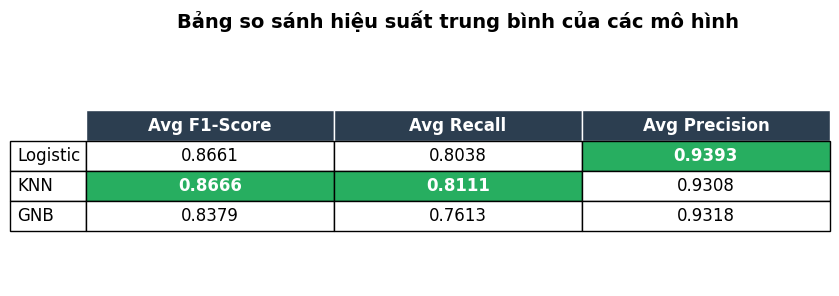

In [66]:
data = np.loadtxt("../data/BankChurners_preprocessed.csv", delimiter=",", skiprows=1)

y = data[:, 0].astype(int)
X = data[:, 1:]

k_fold = 10
k_predict = 5

final_scores = evaluate_models(X, y, k_fold=k_fold, k_predict=k_predict)
draw_performance_table(final_scores)